# rough


In [26]:
# get real balanced data
real = pd.read_csv('PATH_REAL_BALAANCED')

# get unb data
unb = pd.read_csv('PATH_UNB')

In [29]:
target= 'cardio'
ORD = 'cond'

In [27]:
s1 = pd.read_csv('PATH/ablations/cardio/b25/cond1.csv')
s2 = pd.read_csv('PATH/ablations/cardio/b25/cond2.csv')
s3 = pd.read_csv('PATH/ablations/cardio/b25/cond3.csv')
s4 = pd.read_csv('PATH/ablations/cardio/b25/cond4.csv')
s5 = pd.read_csv('PATH/ablations/cardio/b25/cond5.csv')
synth = pd.concat([s1, s2,s3,s4,s5])

# imports

In [1]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import CalibratedClassifierCV

import sdmetrics
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.single_table import (BinaryAdaBoostClassifier, BinaryDecisionTreeClassifier, BinaryLogisticRegression, BinaryMLPClassifier)



# function definitions

In [5]:
def expected_calibration_error(samples, true_labels, M=10, threshold=0.5):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)
    predicted_label = (np.array([x[1] for x in samples]) >= threshold).astype(int)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels
    # print fraction of true
    print(f"Fraction of true: {accuracies.mean()}")
    # print(accuracies)

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()
        # round each val to 3 decimal places

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()

            # print(f"Bin: {bin_lower.item():.3f} - {bin_upper.item():.3f} | Frac: {prob_in_bin:.3f} | Accuracy: {accuracy_in_bin:.3f}")
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece

In [6]:
def xgboost_train(X_train, y_train, EPOCHS=200):
    # defining the XGBoost train and test loaders
    xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)

    # defining the hyperparameters and training the model
    n = EPOCHS
    params = {
        'objective': 'binary:logistic',
        # 'max_depth': 20,
        # 'learning_rate': 0.1,
    }

    model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=n)
    # model = xgb.train(params=params, dtrain=xgb_train)

    # Predicting on the training set
    # preds_train = model.predict(xgb_train)
    # y_pred_train = [round(pred) for pred in preds_train]
    # print(sum(y_pred_train))
    # accuracy = accuracy_score(y_train, y_pred_train)
    # print('Training Accuracy of the model is:', accuracy*100)
    # cm = confusion_matrix(y_train, y_pred_train)
    # ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    return model

In [7]:
def xgb_predict(model, X_test, y_test, threshold=0.5):
    preds = model.predict(xgb.DMatrix(X_test))
    y_pred = [pred>=threshold for pred in preds]
    print(sum(y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print('XG: ', accuracy*100)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    # find minority class accuracy 
    print("Minority class accuracy: ", recall_score(y_test, y_pred, pos_label=1)*100)
    print("Majority class accuracy: ", recall_score(y_test, y_pred, pos_label=0)*100)
    # majority class accuracy
    
    preds = np.array([1-preds, preds]).T
    print("ECE ", expected_calibration_error(preds, y_test))
    roc_curve_plot(y_test, preds[:,1]) 
    # return preds, y_pred

In [8]:
def xgboost(X_train, y_train, X_test, y_test, EPOCHS=200):
    model = xgboost_train(X_train, y_train, EPOCHS)
    xgb_predict(model, X_test, y_test)
    return model

In [9]:
def roc_curve_plot(y_test, y_pred_proba):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure()  
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Classification')
    plt.legend()
    plt.show()

In [37]:
def find_meta_data(df, UNIQ_THRESHOLD=20):
    """segregating all columns into categorical (contains object type, integer
     and float type with lesser than UNIQ_THRESHOLD unique elements), integer type and float type"""

    cat_cols = [col for col in df.columns if df[col].dtype == 'object']
    int_cols = [col for col in df.columns if df[col].dtype == 'int64']
    float_cols = [col for col in df.columns if df[col].dtype == 'float64']
    disc_int_cols = [col for col in int_cols if df[col].nunique()
                     < UNIQ_THRESHOLD]
    disc_float_cols = [
        col for col in float_cols if df[col].nunique() < UNIQ_THRESHOLD]
    discrete_cols = cat_cols + disc_int_cols + disc_float_cols
    int_cols1 = [col for col in int_cols if col not in disc_int_cols]
    float_cols1 = [col for col in float_cols if col not in disc_float_cols]

    # return discrete_cols, int_cols1, float_cols1
    #segregating the columns into categorical, other_int and other_float as done in the HCDR_run notebook
    # discrete_cols, int_cols1, float_cols1 = find_meta_data(df, UNIQ_THRESHOLD=20)


    # Defining the metadata as is required by SDMetrics
    conti_cols = int_cols1 + float_cols1 
    metadata = dict()
    column_dict = dict()
    for col in conti_cols:
        column_dict[col] = {"sdtype": "numerical"}
    for col in discrete_cols:
        column_dict[col] = {"sdtype": "categorical"}
    metadata['columns']  = column_dict
    return metadata


def get_report(real_df, syn_df, metadata):
    report = QualityReport()
    report.generate(real_df, syn_df, metadata)
    print(report)
    return report

def MachineLearningAccuracy(test, train, metadata, target):
    ada = BinaryAdaBoostClassifier.compute(
    test_data=test,
    train_data=train,
    target=target,
    metadata=metadata
    )
    dt = BinaryDecisionTreeClassifier.compute(
        test_data=test,
        train_data=train,
        target=target,
        metadata=metadata
    )
    lr = BinaryLogisticRegression.compute(
        test_data=test,
        train_data=train,
        target=target,
        metadata=metadata
    )

    mlp = BinaryMLPClassifier.compute(
        test_data=test,
        train_data=train,
        target=target,
        metadata=metadata
    )
    print(f"Scores - \nada: {ada}, \ndt: {dt}, \nlr: {lr}, \nmlp: {mlp}")
    # average of 4
    print(f"avg: {(ada+dt+lr+mlp)/4}")
    return (ada+dt+lr+mlp)/4
    

# data

In [10]:
bal_path = 'path_to_real_balanced_data'
unb_path = 'path_to_unbalanced_data'
target = 'income'
ORD = 'ORD'

real = pd.read_csv(bal_path)
unb = pd.read_csv(unb_path)

In [ ]:
synthetic_ORD_path1 = 'path_to_ORD_synthetic_data'
synthetic_ORD_path2 = 'path_to_ORD_synthetic_data'
synthetic_ORD_path3 = 'path_to_ORD_synthetic_data'
synthetic_ORD_path4 = 'path_to_ORD_synthetic_data'
synthetic_ORD_path5 = 'path_to_ORD_synthetic_data'

In [30]:
# sampling the test set from the real balanced data
test0 = real[real[target]==0].sample(2000, random_state=42)
test1 = real[real[target]==1].sample(2000, random_state=42)
test = pd.concat([test0, test1])
X_test = test.drop(target, axis=1)
y_test = test[target]


In [32]:
# concatenating to obtain enough synthetic data
s1 = pd.read_csv(synthetic_ORD_path1)
s2 = pd.read_csv(synthetic_ORD_path2)
s3 = pd.read_csv(synthetic_ORD_path3)
s4 = pd.read_csv(synthetic_ORD_path4)
s5 = pd.read_csv(synthetic_ORD_path5)
synth = pd.concat([s1, s2,s3,s4,s5])

# Classifiers

In [33]:
synth[ORD].value_counts()

cond
0    941468
1     40468
2     18064
Name: count, dtype: int64

In [34]:
synth[target]= synth[ORD].apply(lambda x: 1 if x==2 else 0)

synth2 = synth[synth[ORD]==2]
synth1 = synth[synth[ORD]==1]
synth0 = synth[synth[ORD]==0].sample(len(synth2)+1000, random_state=4)
# Taken 1000 more to have more data without causing much imbalance

## ORD 0,2

1793
XG:  72.32499999999999
Minority class accuracy:  67.15
Majority class accuracy:  77.5
Fraction of true: 0.72325
ECE  [0.05723599]


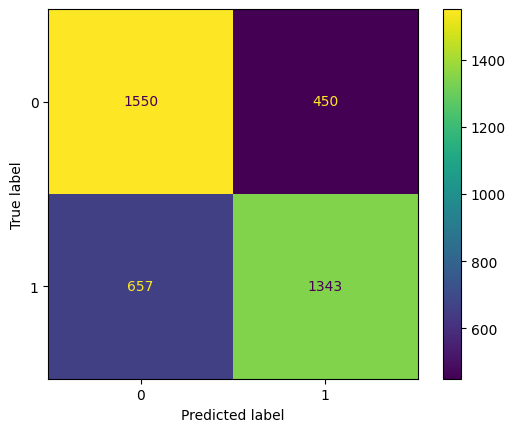

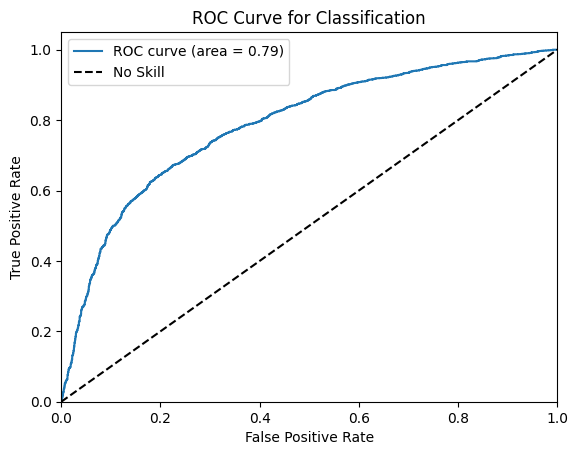

In [35]:

train = pd.concat([synth2, synth0])
train = train.reset_index(drop=True)
train.drop(ORD, axis=1, inplace=True)

X_train = train.drop(target, axis=1)
y_train = train[target]
    
m = xgboost(X_train, y_train, X_test, y_test)


In [38]:
metadata = find_meta_data(train)
MachineLearningAccuracy(test, train, metadata, target)

Scores - 
ada: 0.7044060234244284, 
dt: 0.6796271637816245, 
lr: 0.7218124341412012, 
mlp: 0.7048290830168205
avg: 0.7026686760910186


np.float64(0.7026686760910186)

## ORD 0,2,subsample(1)

1522
XG:  70.35
Minority class accuracy:  58.4
Majority class accuracy:  82.3
Fraction of true: 0.7035
ECE  [0.04596039]


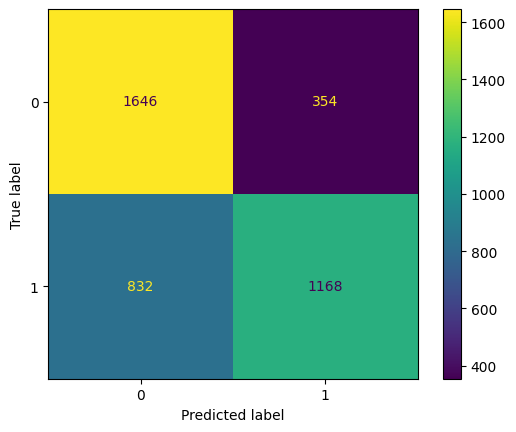

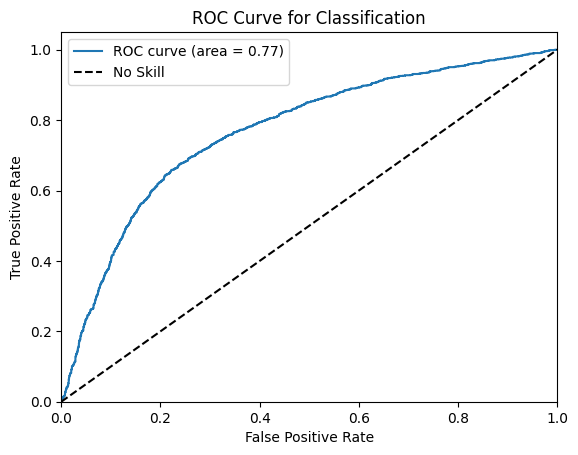

In [39]:
# Can take a different proportion of ORD1 samples
synth1_sub = synth1.sample(n=int(len(synth2)/4), random_state=42)
train = pd.concat([synth2, synth0, synth1_sub])
train = train.reset_index(drop=True)
train.drop(ORD, axis=1, inplace=True)

X_train = train.drop(target, axis=1)
y_train = train[target]
    
m = xgboost(X_train, y_train, X_test, y_test)


In [41]:
metadata = find_meta_data(train)
MachineLearningAccuracy(test, train, metadata, target)

Scores - 
ada: 0.6647093364650617, 
dt: 0.6535195836757053, 
lr: 0.6934865900383141, 
mlp: 0.6841371619737943
avg: 0.6739631680382189


np.float64(0.6739631680382189)

## ORD 0,2 + Real Minority

1967
XG:  81.175
Minority class accuracy:  80.35
Majority class accuracy:  82.0
Fraction of true: 0.81175
ECE  [0.05598479]


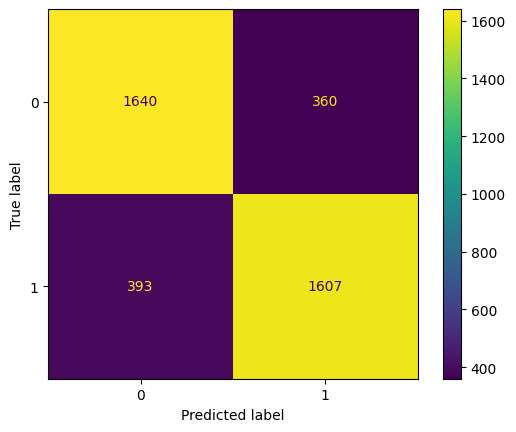

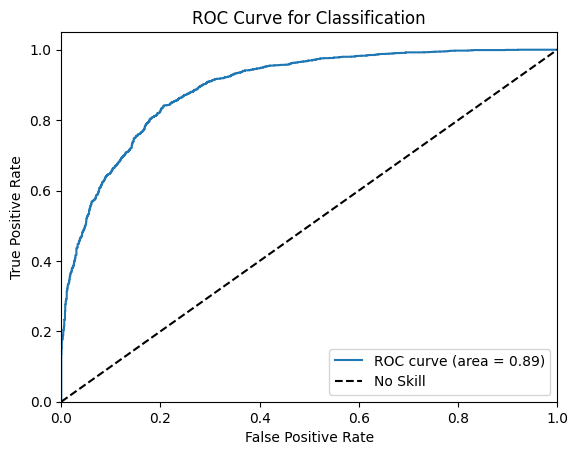

In [ ]:
real_min = unb[unb[target]==1]

train = pd.concat([synth2, synth0])
train.drop(ORD, axis=1, inplace=True)
train = pd.concat([train, real_min])
train = train.reset_index(drop=True)

X_train = train.drop(target, axis=1)
y_train = train[target]
    
m = xgboost(X_train, y_train, X_test, y_test)


In [ ]:
metadata = find_meta_data(train)
MachineLearningAccuracy(test, train, metadata)

## ORD 0,2 + Real Minority + Real Majority

1853
XG:  81.825
Minority class accuracy:  78.14999999999999
Majority class accuracy:  85.5
Fraction of true: 0.81825
ECE  [0.04318037]


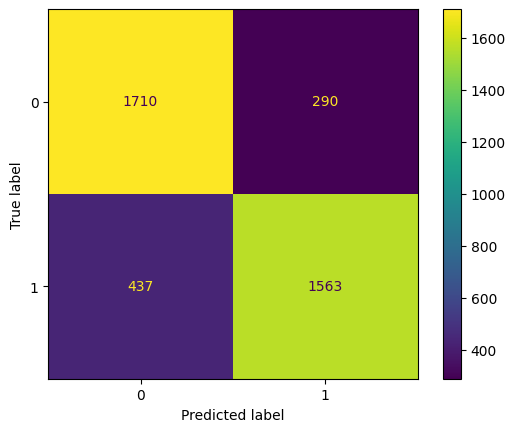

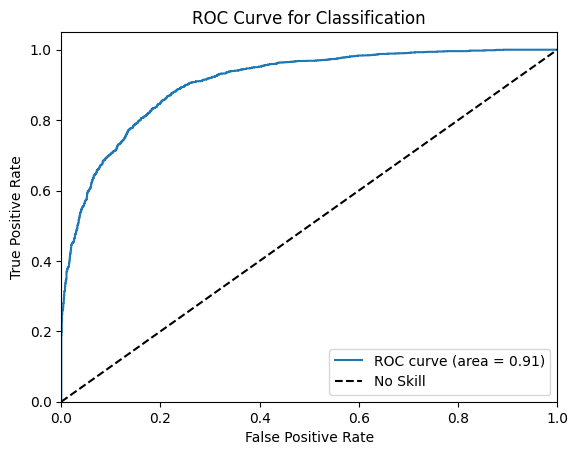

In [ ]:
real_min = unb[unb[target]==1]
real_maj = unb[unb[target]==0].sample(n=int(len(real_min)*2), random_state=42)
# can change the proportion of real majority sampled

train = pd.concat([synth2, synth0])
train.drop(ORD, axis=1, inplace=True)
train = pd.concat([train, real_min, real_maj])
train = train.reset_index(drop=True)

X_train = train.drop(target, axis=1)
y_train = train[target]
    
m = xgboost(X_train, y_train, X_test, y_test)


In [ ]:
metadata = find_meta_data(train)
MachineLearningAccuracy(test, train, metadata)